# Data processing 
This notebook is intended to work through the whole data processing
pipeline, making all the corrections to the observed travel times such
that we can try to invert for CMB topography. We'll need access to all
the tools, so do something like this before starting:

    export PYTHONPATH="../tools:../:../tools/packages/lib/python/:../tools/tomocorr"
    
(and make sure you can run the other notebooks

In [1]:
# Environment setup - quite a lot here

# Make pictures show up in the web browser,
# import matplotlib etc, and make the figures
# big
%matplotlib inline
import matplotlib 
import matplotlib.pyplot as plt
import mpl_toolkits.basemap as basemap
plt.rcParams['figure.figsize'] = (12, 8)

# Other "standard" modules
import pandas
import numpy as np

# Get access to taup
import obspy.taup

# Geodesic calculations
import geographiclib.geodesic as geod

# Our ISC parser
import read_ISC

# tomographic correction
import tomocorr2

# Our ellipticity corrections
import ellippy

## Read and plot data
Here we read in the EQ data and load it into
a Pandas dataframe. We then calculate travel
times and store these in seconds (not deltatime
objects).

In [2]:
all_picks = read_ISC.read_picks('../data/ISC_Jan_2012_trim.dat', ('P', 'PcP'))
paired_picks = read_ISC.pair_picks(all_picks, 'PcP', 'P')

# Put in a dataframe
paired_picks_df = pandas.DataFrame.from_dict(paired_picks, orient='index')

# Remove Pdiff
paired_picks_df = paired_picks_df[(paired_picks_df.epicentral_distance < 80)]

# Remove P triplications
paired_picks_df = paired_picks_df[(paired_picks_df.epicentral_distance > 30)]

# Calculate PcP and P travel time (and store as a real in seconds)
paired_picks_df["PcP_ttime"] = (paired_picks_df.PcP_datetime - 
                                paired_picks_df.event_datetime).values / np.timedelta64(1, 's')
paired_picks_df["P_ttime"] = (paired_picks_df.P_datetime - 
                              paired_picks_df.event_datetime).values / np.timedelta64(1, 's')


In [3]:
# Just look at the data
paired_picks_df

,eventid,P_datetime,station_lon,reporter,PcP_datetime,epicentral_distance,station_elev,event_lat,station,backazimuth,event_depth,event_lon,event_datetime,station_lat,PcP_ttime,P_ttime
600130102GTABJI,600130102,2012-01-01 00:38:39.200,99.8144,BJI,2012-01-01 00:40:10.900,47.42,1341.0,11.9775,GTA,313.2,27.5,143.7081,2012-01-01 00:30:07.200,39.4106,603.70,512.00
600130102GYABJI,600130102,2012-01-01 00:37:21.200,106.6640,BJI,2012-01-01 00:39:38.700,37.67,1162.0,11.9775,GYA,297.9,27.5,143.7081,2012-01-01 00:30:07.200,26.4586,571.50,434.00
600130102KLRIDC,600130102,2012-01-01 00:37:25.400,131.7500,IDC,2012-01-01 00:39:39.170,38.44,298.0,11.9775,KLR,347.4,27.5,143.7081,2012-01-01 00:30:07.200,49.2300,571.97,438.20
600130102KSHBJI,600130102,2012-01-01 00:40:50.000,75.9731,BJI,2012-01-01 00:41:23.300,65.33,1314.0,11.9775,KSH,308.0,27.5,143.7081,2012-01-01 00:30:07.200,39.5167,676.10,642.80
600130102PETKIDC,600130102,2012-01-01 00:38:00.270,157.6989,IDC,2012-01-01 00:39:51.750,42.53,400.0,11.9775,PETK,12.5,27.5,143.7081,2012-01-01 00:30:07.200,53.1082,584.55,473.07
600130102SONMIDC,600130102,2012-01-01 00:38:39.360,106.3950,IDC,2012-01-01 00:40:09.380,47.41,1415.8,11.9775,SONM,326.3,27.5,143.7081,2012-01-01 00:30:07.200,47.8347,602.18,512.16
600130102ZALVIDC,600130102,2012-01-01 00:40:26.100,84.8188,IDC,2012-01-01 00:41:05.750,62.28,229.4,11.9775,ZALV,325.1,27.5,143.7081,2012-01-01 00:30:07.200,53.9481,658.55,618.90
600130103AS01NEIC,600130103,2012-01-01 00:56:35.790,133.9510,NEIC,2012-01-01 00:59:19.090,33.03,605.0,-11.3505,AS01,243.9,37.0,166.2200,2012-01-01 00:50:04.840,-23.6647,554.25,390.95
600130103ASARIDC,600130103,2012-01-01 00:56:36.100,133.9040,IDC,2012-01-01 00:59:19.400,33.07,607.0,-11.3505,ASAR,243.9,37.0,166.2200,2012-01-01 00:50:04.840,-23.6664,554.56,391.26
600130103STKAIDC,600130103,2012-01-01 00:56:15.400,141.5952,IDC,2012-01-01 00:59:13.370,30.55,272.3,-11.3505,STKA,224.2,37.0,166.2200,2012-01-01 00:50:04.840,-31.8769,548.53,370.56


In [37]:
paired_picks_df.shape

(1987, 32)

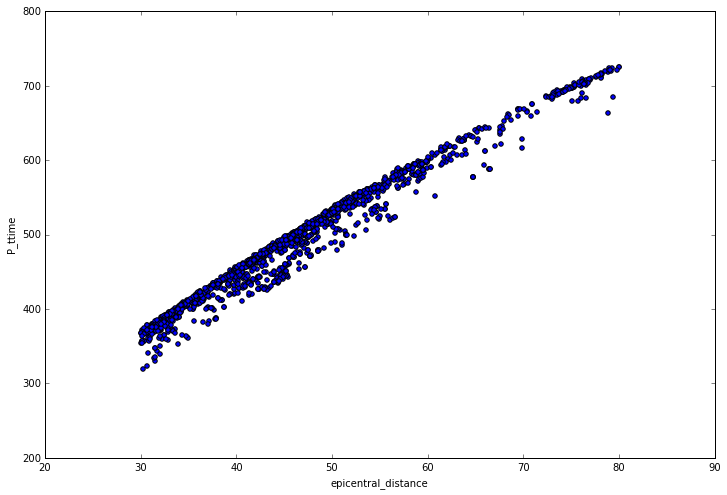

In [4]:
# Plot P travel times
paired_picks_df.plot(kind='scatter', x='epicentral_distance', y='P_ttime')

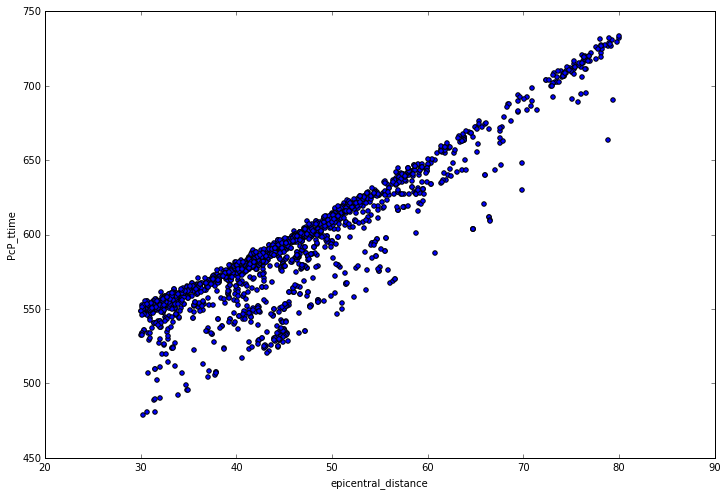

In [5]:
# Plot PcP travel times
paired_picks_df.plot(kind='scatter', x='epicentral_distance', y='PcP_ttime')

## Bounce points on the CMB
We'll use a 1D model to work out the bounce points for
PcP on the CMB and add these to the dataframe. We can
then use these to plot data geographically.

In [6]:
# We need a taup model that knows about 
# location. We've got one of these (it's
# a subclass of obspy.tau) and it lives
# in our tomography correction code for
# now. We'll assume a spherical Earth 
# (see below for the correction for
# this).
taup_model = tomocorr2.TauPyModelGeo(model="iasp91", 
                                     ellipsoid=geod.Geodesic(a=6371000.0, f=0))

# Function to find the bounce point
def calc_bounce_point_lat(source_depth, source_lat, source_lon, station_lat, station_lon):
    arrivals = taup_model.get_pierce_points_geo(source_depth, source_lat, source_lon,
                                                station_lat, station_lon, ['PcP'])
    # Our list of arrivals should always have just one arrival (for PcP)
    # so we will use this, and extract the lat and lon at the CMB depth
    lat = arrivals[0].pierce[arrivals[0].pierce['depth'] == 2889.0]['lat']
    return lat[0]

def calc_bounce_point_lon(source_depth, source_lat, source_lon, station_lat, station_lon):
    arrivals = taup_model.get_pierce_points_geo(source_depth, source_lat, source_lon,
                                                station_lat, station_lon, ['PcP'])
    # Our list of arrivals should always have just one arrival (for PcP)
    # so we will use this, and extract the lat and lon at the CMB depth
    lon = arrivals[0].pierce[arrivals[0].pierce['depth'] == 2889.0]['lon']
    return lon[0]

paired_picks_df['CMB_bounce_lat'] = paired_picks_df.apply(
    lambda row: calc_bounce_point_lat(row['event_depth'], 
                                      row['event_lat'],
                                      row['event_lon'], 
                                      row['station_lat'],
                                      row['station_lon']), axis=1)
  
paired_picks_df['CMB_bounce_lon'] = paired_picks_df.apply(
    lambda row: calc_bounce_point_lon(row['event_depth'], 
                                      row['event_lat'],
                                      row['event_lon'], 
                                      row['station_lat'],
                                      row['station_lon']), axis=1)

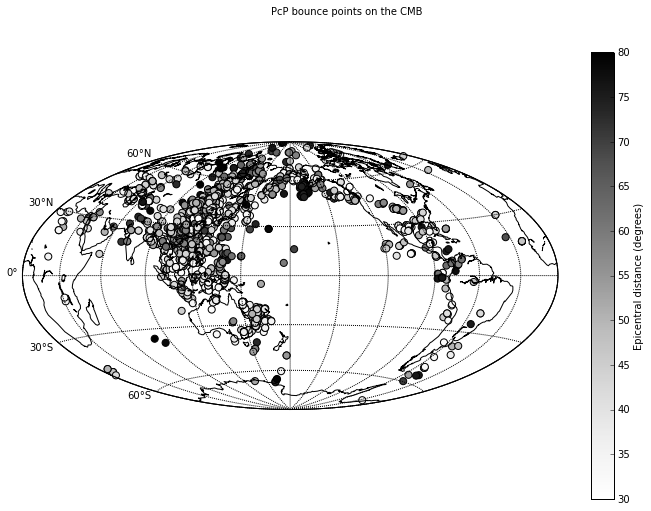

In [7]:
# Plot the bounce points, so 
# we can see where we have data

fig = plt.figure()
axis = fig.add_subplot(1,1,1)
map = basemap.Basemap(projection='hammer',
                      lat_0=0.0, lon_0=180.0, resolution='c', ax=axis)

map.drawcoastlines()
map.drawmapboundary()
map.drawmeridians(np.arange(-180,180,30), labels=[0,0,0,0])
map.drawparallels(np.arange(-90,90,30), labels=[1,0,0,0])

# we need to find the x, y position of the data given
# the map projection.
lonp, latp = map(
    paired_picks_df.CMB_bounce_lon.values, 
    paired_picks_df.CMB_bounce_lat.values)

# plot the data - colour by epicentral distance
sc = map.scatter(lonp, latp, 
                 c=paired_picks_df.epicentral_distance.values, 
                 cmap=plt.cm.Greys, s=50)

cb = plt.colorbar(sc)
cb.ax.set_ylabel('Epicentral distance (degrees)')
fig.suptitle('PcP bounce points on the CMB')
plt.show()    

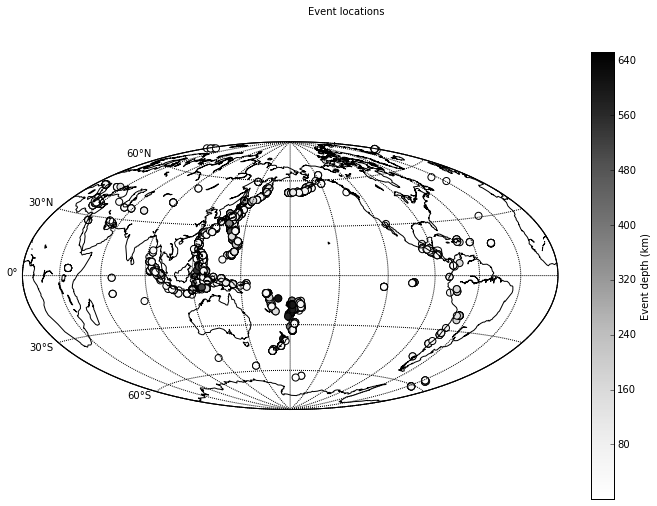

In [8]:
# Plot the events, so 
# we can see where we have data

fig = plt.figure()
axis = fig.add_subplot(1,1,1)
map = basemap.Basemap(projection='hammer',
                      lat_0=0.0, lon_0=180.0, resolution='c', ax=axis)

map.drawcoastlines()
map.drawmapboundary()
map.drawmeridians(np.arange(-180,180,30), labels=[0,0,0,0])
map.drawparallels(np.arange(-90,90,30), labels=[1,0,0,0])

# we need to find the x, y position of the data given
# the map projection.
lonp, latp = map(
    paired_picks_df.event_lon.values, 
    paired_picks_df.event_lat.values)

# plot the data - colour by epicentral distance
sc = map.scatter(lonp, latp, 
                 c=paired_picks_df.event_depth.values, 
                 cmap=plt.cm.Greys, s=50)

cb = plt.colorbar(sc)
cb.ax.set_ylabel('Event depth (km)')
fig.suptitle('Event locations')
plt.show() 

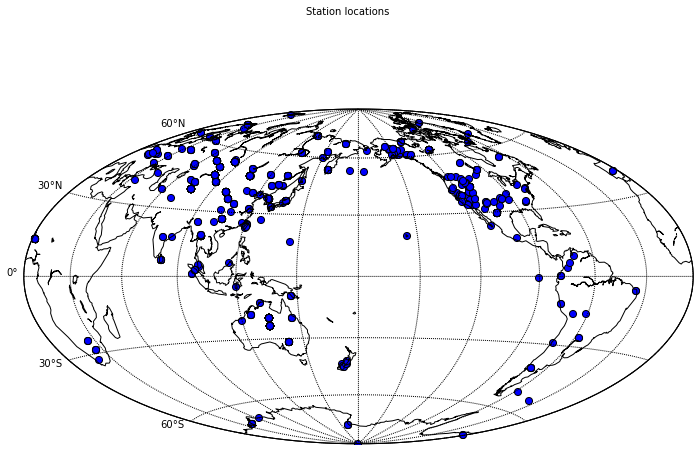

In [9]:
# Plot the stations, so 
# we can see where we have data

fig = plt.figure()
axis = fig.add_subplot(1,1,1)
map = basemap.Basemap(projection='hammer',
                      lat_0=0.0, lon_0=180.0, resolution='c', ax=axis)

map.drawcoastlines()
map.drawmapboundary()
map.drawmeridians(np.arange(-180,180,30), labels=[0,0,0,0])
map.drawparallels(np.arange(-90,90,30), labels=[1,0,0,0])

# we need to find the x, y position of the data given
# the map projection.
lonp, latp = map(
    paired_picks_df.station_lon.values, 
    paired_picks_df.station_lat.values)

# plot the data - colour by epicentral distance
sc = map.scatter(lonp, latp, s=50)

fig.suptitle('Station locations')
plt.show() 

## Calculate travel time for 1D Earth model
We will store the calculated P and PcP travel time for each event,
then evaluate PcP - P for the data and the model.

In [10]:
# NB - we are using the same taup_model for this

def calc_P(epi, z):
    arrivals = taup_model.get_travel_times(z, epi, phase_list=['P'])
    # Use the last arrival as PcP - to avoid problems with
    # P triplications.
    P_time = arrivals[0].time
    return P_time

def calc_PcP(epi, z):
    arrivals = taup_model.get_travel_times(z, epi, phase_list=['PcP'])
    # Use the last arrival as PcP - to avoid problems with
    # P triplications.
    PcP_time = arrivals[0].time
    return PcP_time

paired_picks_df["P_ttime_calc"] = paired_picks_df.apply(
    lambda row: calc_P(row['epicentral_distance'], row['event_depth']), axis=1)

paired_picks_df["PcP_ttime_calc"] = paired_picks_df.apply(
    lambda row: calc_PcP(row['epicentral_distance'], row['event_depth']), axis=1)

In [11]:
# differential travel times, and residual

paired_picks_df["PcP_P_dtime_calc"] = paired_picks_df.PcP_ttime_calc - \
    paired_picks_df.P_ttime_calc
    
paired_picks_df["PcP_P_dtime"] = paired_picks_df.PcP_ttime - paired_picks_df.P_ttime
    
paired_picks_df["PcP_P_dtime_resid"] = paired_picks_df.PcP_P_dtime - \
    paired_picks_df.PcP_P_dtime_calc

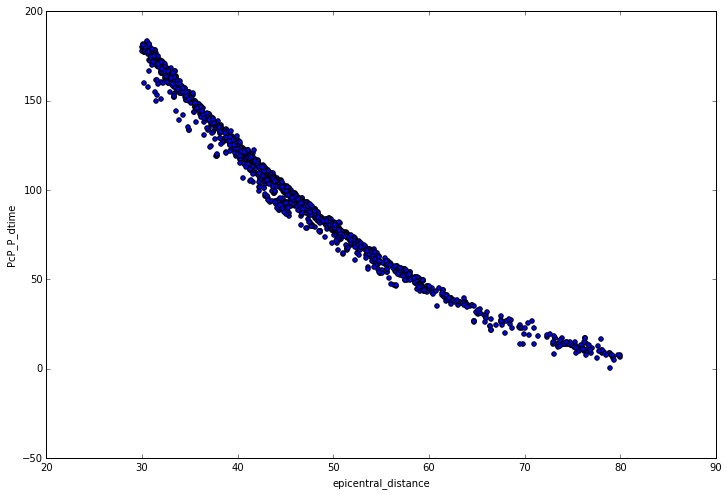

In [12]:
paired_picks_df.plot(kind='scatter', x='epicentral_distance', y='PcP_P_dtime')

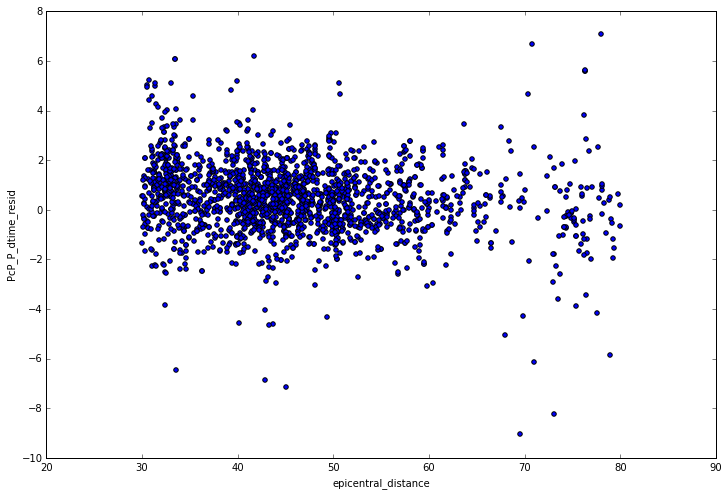

In [13]:
paired_picks_df.plot(kind='scatter', x='epicentral_distance', y='PcP_P_dtime_resid')

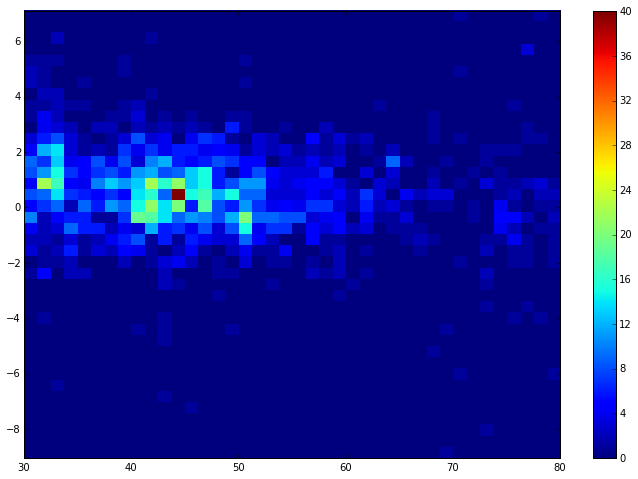

In [14]:
plt.hist2d(paired_picks_df.epicentral_distance.values, 
       paired_picks_df.PcP_P_dtime_resid.values, 
       bins=40)
plt.colorbar()
plt.show()

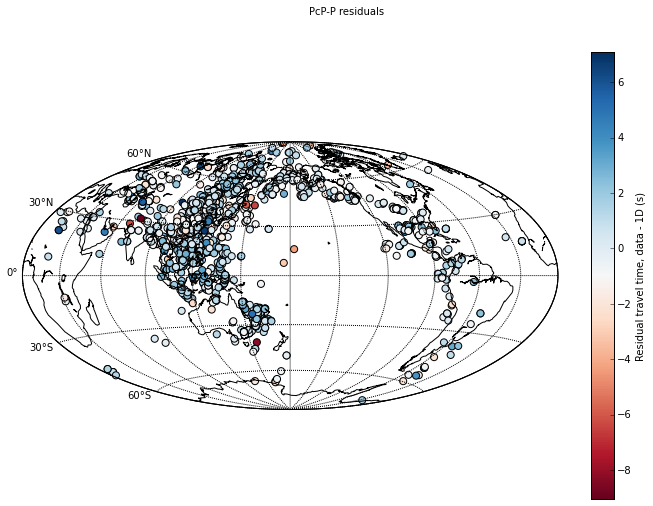

In [46]:
# Plot the bounce points, so 
# we can see where we have data

fig = plt.figure()
axis = fig.add_subplot(1,1,1)
map = basemap.Basemap(projection='hammer',
                      lat_0=0.0, lon_0=180.0, resolution='c', ax=axis)

map.drawcoastlines()
map.drawmapboundary()
map.drawmeridians(np.arange(-180,180,30), labels=[0,0,0,0])
map.drawparallels(np.arange(-90,90,30), labels=[1,0,0,0])

# we need to find the x, y position of the data given
# the map projection.
lonp, latp = map(
    paired_picks_df.CMB_bounce_lon.values, 
    paired_picks_df.CMB_bounce_lat.values)

# plot the data - colour by epicentral distance
sc = map.scatter(lonp, latp, 
                 c=paired_picks_df.PcP_P_dtime_resid.values, 
                 cmap=plt.cm.RdBu, s=50)


cb = plt.colorbar(sc)
cb.ax.set_ylabel('Residual travel time, data - 1D (s)')
fig.suptitle('PcP-P residuals')
plt.show()

## Ellipticity correction
For this we are stuck with a wrapper around
the Fortran code. At some point somebody could
code up the raypath integrals...

In [16]:
# We need the event -> station azimuth. Assume elliptical 
# earth for this, but the difference is small (much smaller
# than what comes from the main ellipticity correction). We 
# can do this with geographiclib 

ellipsoid=geod.Geodesic.WGS84

def get_azimuth(source_latitude_in_deg, source_longitude_in_deg,
                station_latitude_in_deg, station_longitude_in_deg):
    
    g = ellipsoid.Inverse(source_latitude_in_deg, source_longitude_in_deg,
                              station_latitude_in_deg, station_longitude_in_deg)
    return g['azi1']

paired_picks_df["azimuth"] = paired_picks_df.apply(
    lambda row: get_azimuth(row['event_lat'], 
                            row['event_lon'], 
                            row['station_lat'],
                            row['station_lon']), axis=1)


In [17]:
# Setup direct access tables
ellippy.ellip_setup()

paired_picks_df["P_ellip_corr"] = paired_picks_df.apply(
    lambda row: ellippy.ellip_correct(row['event_lat'], 
                                      row['event_depth'], 
                                      row['azimuth'],
                                      row['epicentral_distance'], 'P'), axis=1)

paired_picks_df["PcP_ellip_corr"] = paired_picks_df.apply(
    lambda row: ellippy.ellip_correct(row['event_lat'], 
                                      row['event_depth'], 
                                      row['azimuth'],
                                      row['epicentral_distance'], 'PcP'), axis=1)

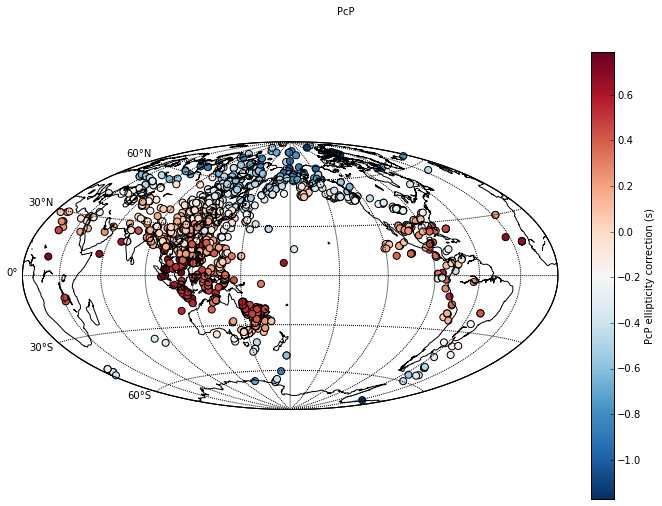

In [18]:
# Plot the corrections

fig = plt.figure()
axis = fig.add_subplot(1,1,1)
map = basemap.Basemap(projection='hammer',
                      lat_0=0.0, lon_0=180.0, resolution='c', ax=axis)

map.drawcoastlines()
map.drawmapboundary()
map.drawmeridians(np.arange(-180,180,30), labels=[0,0,0,0])
map.drawparallels(np.arange(-90,90,30), labels=[1,0,0,0])

# we need to find the x, y position of the data given
# the map projection.
lonp, latp = map(
    paired_picks_df.CMB_bounce_lon.values, 
    paired_picks_df.CMB_bounce_lat.values)

# plot the data - colour by epicentral distance
sc = map.scatter(lonp, latp, 
                 c=paired_picks_df.PcP_ellip_corr.values, 
                 cmap=plt.cm.RdBu_r, s=50)

cb = plt.colorbar(sc)
cb.ax.set_ylabel('PcP ellipticity correction (s)')
fig.suptitle('PcP')
plt.show()

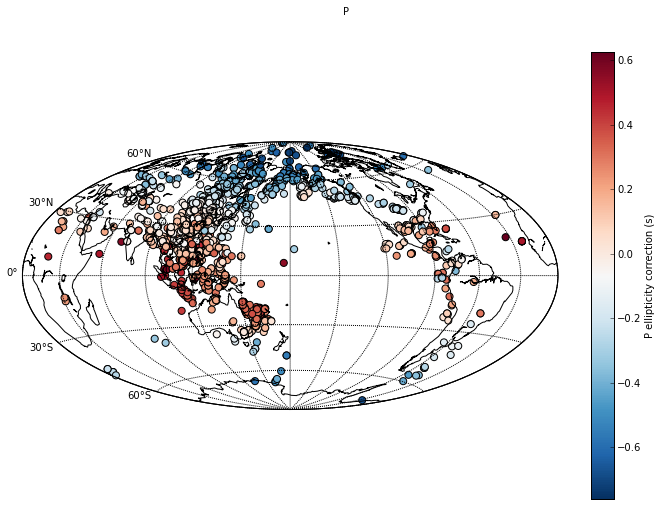

In [19]:
# Plot the corrections

fig = plt.figure()
axis = fig.add_subplot(1,1,1)
map = basemap.Basemap(projection='hammer',
                      lat_0=0.0, lon_0=180.0, resolution='c', ax=axis)

map.drawcoastlines()
map.drawmapboundary()
map.drawmeridians(np.arange(-180,180,30), labels=[0,0,0,0])
map.drawparallels(np.arange(-90,90,30), labels=[1,0,0,0])

# we need to find the x, y position of the data given
# the map projection.
lonp, latp = map(
    paired_picks_df.CMB_bounce_lon.values, 
    paired_picks_df.CMB_bounce_lat.values)

# plot the data - colour by epicentral distance
sc = map.scatter(lonp, latp, 
                 c=paired_picks_df.P_ellip_corr.values, 
                 cmap=plt.cm.RdBu_r, s=50)

cb = plt.colorbar(sc)
cb.ax.set_ylabel('P ellipticity correction (s)')
fig.suptitle('P')
plt.show()

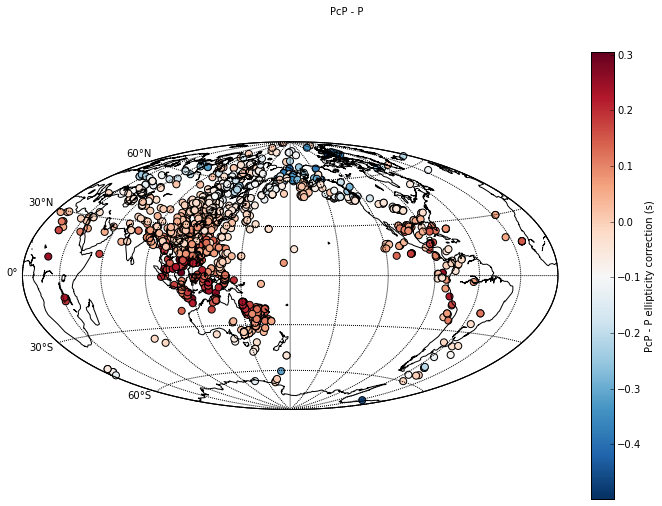

In [20]:

fig = plt.figure()
axis = fig.add_subplot(1,1,1)
map = basemap.Basemap(projection='hammer',
                      lat_0=0.0, lon_0=180.0, resolution='c', ax=axis)

map.drawcoastlines()
map.drawmapboundary()
map.drawmeridians(np.arange(-180,180,30), labels=[0,0,0,0])
map.drawparallels(np.arange(-90,90,30), labels=[1,0,0,0])

# we need to find the x, y position of the data given
# the map projection.
lonp, latp = map(
    paired_picks_df.CMB_bounce_lon.values, 
    paired_picks_df.CMB_bounce_lat.values)

# plot the data - colour by epicentral distance
sc = map.scatter(lonp, latp, 
                 c=(paired_picks_df.PcP_ellip_corr.values - 
                    paired_picks_df.P_ellip_corr.values), 
                 cmap=plt.cm.RdBu_r, s=50)

cb = plt.colorbar(sc)
cb.ax.set_ylabel('PcP - P ellipticity correction (s)')
fig.suptitle('PcP - P')
plt.show()

## Tomographic correction

In [21]:
# Setup the tomography model - you can only do this once
# (Fortran limitation)
corrector = tomocorr2.TomographicCorrection('../tools/tomocorr/ak135.1D_vp', 
                                            '../tools/tomocorr/vdh3D_1999', 
                                            ellipsoid=geod.Geodesic(a=6371000.0, f=0))

In [22]:
# Calculate tomoraphic corrections - this takes a few mins...
paired_picks_df["P_tomo_corr"] = paired_picks_df.apply(
    lambda row: corrector.calculate(row['event_lat'],
                                    row['event_lon'],
                                    row['event_depth'],
                                    row['station_lat'],
                                    row['station_lon'], ['P'])[0], axis=1)

paired_picks_df["PcP_tomo_corr"] = paired_picks_df.apply(
    lambda row: corrector.calculate(row['event_lat'],
                                    row['event_lon'],
                                    row['event_depth'],
                                    row['station_lat'],
                                    row['station_lon'], ['PcP'])[0], axis=1)

In [23]:
# It turns out we have one bogus (probably)
# path, giving ~20 s of P and PcP correction.
# The bounce point is off N Japan...
print paired_picks_df[(paired_picks_df.PcP_tomo_corr < -10.0)]

# We will remove this:
paired_picks_df = paired_picks_df[(paired_picks_df.PcP_tomo_corr > -10.0)]

                      eventid              P_datetime  station_lon reporter  \
600476354SONA0NEIC  600476354 2012-01-19 02:28:55.800      106.395     NEIC   
600476354SONMIDC    600476354 2012-01-19 02:28:55.800      106.395      IDC   

                              PcP_datetime  epicentral_distance  station_elev  \
600476354SONA0NEIC 2012-01-19 02:30:29.770                46.36        1415.8   
600476354SONMIDC   2012-01-19 02:30:29.760                46.36        1415.8   

                    event_lat station  backazimuth      ...        \
600476354SONA0NEIC    51.6319   SONA0        296.2      ...         
600476354SONMIDC      51.6319    SONM        296.2      ...         

                    P_ttime_calc  PcP_ttime_calc PcP_P_dtime_calc  \
600476354SONA0NEIC    504.306308       598.98161        94.675302   
600476354SONMIDC      504.306308       598.98161        94.675302   

                    PcP_P_dtime  PcP_P_dtime_resid    azimuth  P_ellip_corr  \
600476354SONA0NEIC     

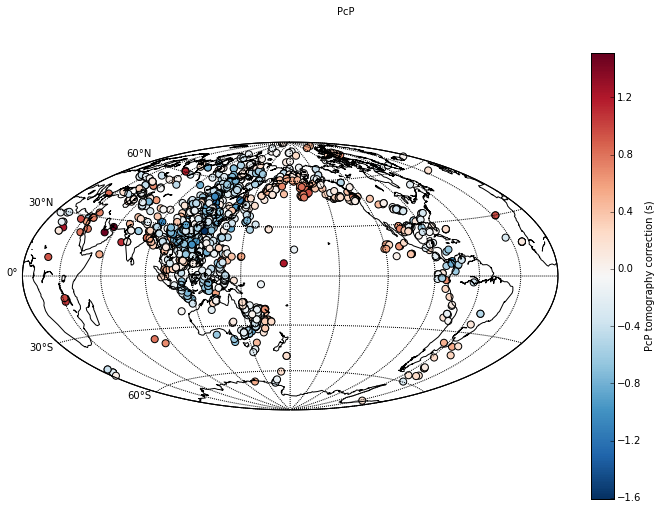

In [24]:
# Plot the corrections

fig = plt.figure()
axis = fig.add_subplot(1,1,1)
map = basemap.Basemap(projection='hammer',
                      lat_0=0.0, lon_0=180.0, resolution='c', ax=axis)

map.drawcoastlines()
map.drawmapboundary()
map.drawmeridians(np.arange(-180,180,30), labels=[0,0,0,0])
map.drawparallels(np.arange(-90,90,30), labels=[1,0,0,0])

# we need to find the x, y position of the data given
# the map projection.
lonp, latp = map(
    paired_picks_df.CMB_bounce_lon.values, 
    paired_picks_df.CMB_bounce_lat.values)

# plot the data - colour by epicentral distance
sc = map.scatter(lonp, latp, 
                 c=paired_picks_df.PcP_tomo_corr.values, 
                 cmap=plt.cm.RdBu_r, s=50)

cb = plt.colorbar(sc)
cb.ax.set_ylabel('PcP tomography correction (s)')
fig.suptitle('PcP')
plt.show()

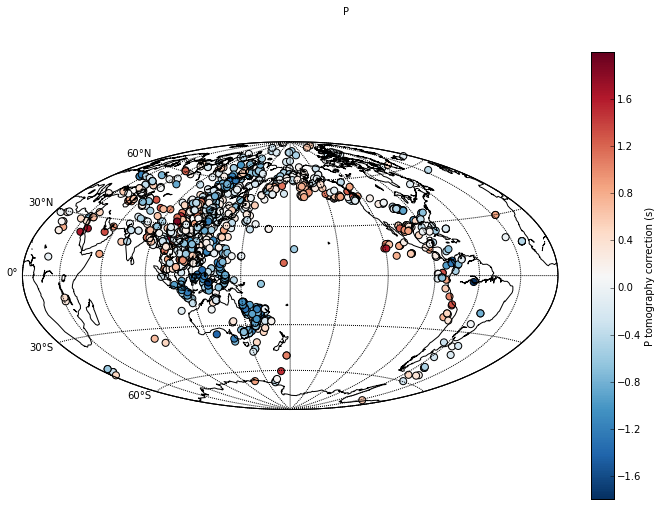

In [25]:
# Plot the corrections

fig = plt.figure()
axis = fig.add_subplot(1,1,1)
map = basemap.Basemap(projection='hammer',
                      lat_0=0.0, lon_0=180.0, resolution='c', ax=axis)

map.drawcoastlines()
map.drawmapboundary()
map.drawmeridians(np.arange(-180,180,30), labels=[0,0,0,0])
map.drawparallels(np.arange(-90,90,30), labels=[1,0,0,0])

# we need to find the x, y position of the data given
# the map projection.
lonp, latp = map(
    paired_picks_df.CMB_bounce_lon.values, 
    paired_picks_df.CMB_bounce_lat.values)

# plot the data - colour by epicentral distance
sc = map.scatter(lonp, latp, 
                 c=paired_picks_df.P_tomo_corr.values, 
                 cmap=plt.cm.RdBu_r, s=50)

cb = plt.colorbar(sc)
cb.ax.set_ylabel('P tomography correction (s)')
fig.suptitle('P')
plt.show()

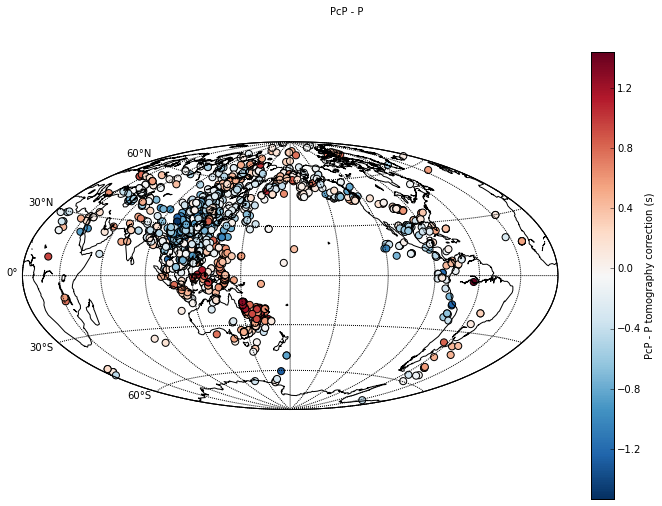

In [26]:
# Plot the corrections

fig = plt.figure()
axis = fig.add_subplot(1,1,1)
map = basemap.Basemap(projection='hammer',
                      lat_0=0.0, lon_0=180.0, resolution='c', ax=axis)

map.drawcoastlines()
map.drawmapboundary()
map.drawmeridians(np.arange(-180,180,30), labels=[0,0,0,0])
map.drawparallels(np.arange(-90,90,30), labels=[1,0,0,0])

# we need to find the x, y position of the data given
# the map projection.
lonp, latp = map(
    paired_picks_df.CMB_bounce_lon.values, 
    paired_picks_df.CMB_bounce_lat.values)

# plot the data - colour by epicentral distance
sc = map.scatter(lonp, latp, 
                 c=(paired_picks_df.PcP_tomo_corr.values -
                    paired_picks_df.P_tomo_corr.values), 
                 cmap=plt.cm.RdBu_r, s=50)

cb = plt.colorbar(sc)
cb.ax.set_ylabel('PcP - P tomography correction (s)')
fig.suptitle('PcP - P')
plt.show()

## Apply the corrections
Add the corrections to the data to remove
the ellipticity and mantle structure. This
Should leave something we can use to invert
for CMB topography and crustal structure.

In [27]:
paired_picks_df["P_ttime_corrected"] = paired_picks_df.P_ttime + \
    paired_picks_df.P_tomo_corr + paired_picks_df.P_ellip_corr
    
paired_picks_df["PcP_ttime_corrected"] = paired_picks_df.PcP_ttime + \
    paired_picks_df.PcP_tomo_corr + paired_picks_df.PcP_ellip_corr

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [28]:
paired_picks_df["PcP_P_dtime_corrected"] = paired_picks_df.PcP_ttime_corrected - \
    paired_picks_df.P_ttime_corrected
    
paired_picks_df["PcP_P_dtime_corrected_resid"] = paired_picks_df.PcP_P_dtime_corrected - \
    paired_picks_df.PcP_P_dtime_calc

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


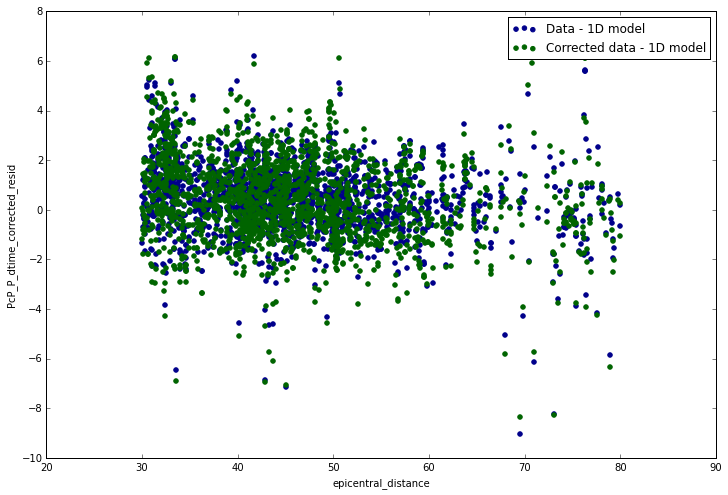

In [29]:
ax = paired_picks_df.plot(kind='scatter', x='epicentral_distance', y='PcP_P_dtime_resid', 
                          color='DarkBlue', label='Data - 1D model')
paired_picks_df.plot(kind='scatter', x='epicentral_distance', y='PcP_P_dtime_corrected_resid', 
                          color='DarkGreen', label='Corrected data - 1D model', ax=ax)

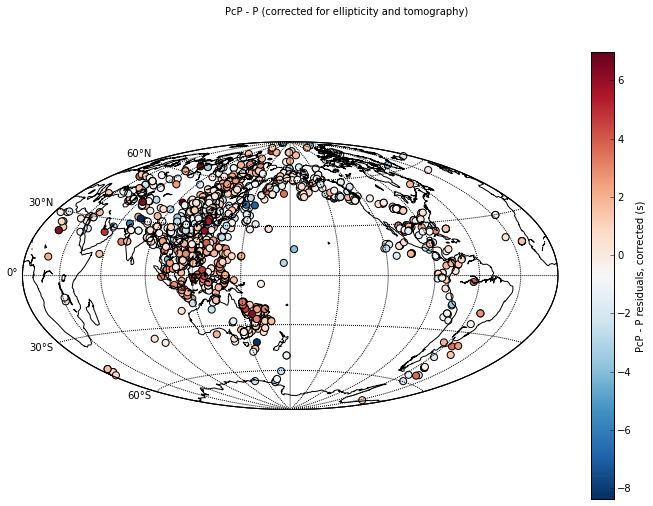

In [30]:
# Plot the residual

fig = plt.figure()
axis = fig.add_subplot(1,1,1)
map = basemap.Basemap(projection='hammer',
                      lat_0=0.0, lon_0=180.0, resolution='c', ax=axis)

map.drawcoastlines()
map.drawmapboundary()
map.drawmeridians(np.arange(-180,180,30), labels=[0,0,0,0])
map.drawparallels(np.arange(-90,90,30), labels=[1,0,0,0])

# we need to find the x, y position of the data given
# the map projection.
lonp, latp = map(
    paired_picks_df.CMB_bounce_lon.values, 
    paired_picks_df.CMB_bounce_lat.values)

# plot the data - colour by epicentral distance
sc = map.scatter(lonp, latp, 
                 c=(paired_picks_df.PcP_P_dtime_corrected_resid.values), 
                 cmap=plt.cm.RdBu_r, s=50)

cb = plt.colorbar(sc)
cb.ax.set_ylabel('PcP - P residuals, corrected (s)')
fig.suptitle('PcP - P (corrected for ellipticity and tomography)')
plt.show()

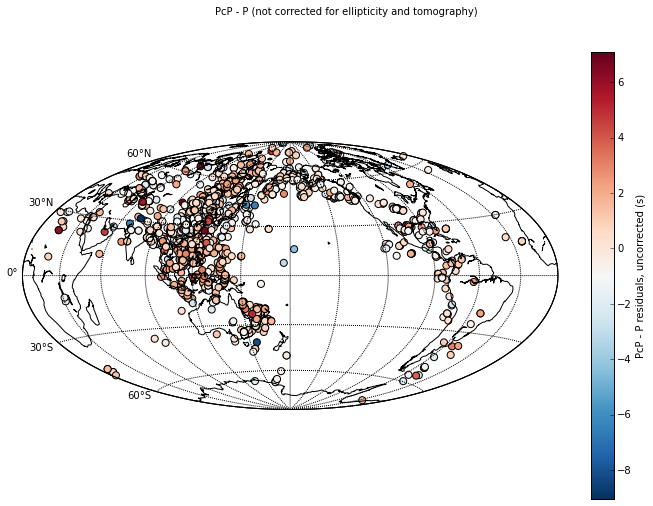

In [31]:
# Plot the residual

fig = plt.figure()
axis = fig.add_subplot(1,1,1)
map = basemap.Basemap(projection='hammer',
                      lat_0=0.0, lon_0=180.0, resolution='c', ax=axis)

map.drawcoastlines()
map.drawmapboundary()
map.drawmeridians(np.arange(-180,180,30), labels=[0,0,0,0])
map.drawparallels(np.arange(-90,90,30), labels=[1,0,0,0])

# we need to find the x, y position of the data given
# the map projection.
lonp, latp = map(
    paired_picks_df.CMB_bounce_lon.values, 
    paired_picks_df.CMB_bounce_lat.values)

# plot the data - colour by epicentral distance
sc = map.scatter(lonp, latp, 
                 c=(paired_picks_df.PcP_P_dtime_resid.values), 
                 cmap=plt.cm.RdBu_r, s=50)

cb = plt.colorbar(sc)
cb.ax.set_ylabel('PcP - P residuals, uncorrected (s)')
fig.suptitle('PcP - P (not corrected for ellipticity and tomography)')
plt.show()

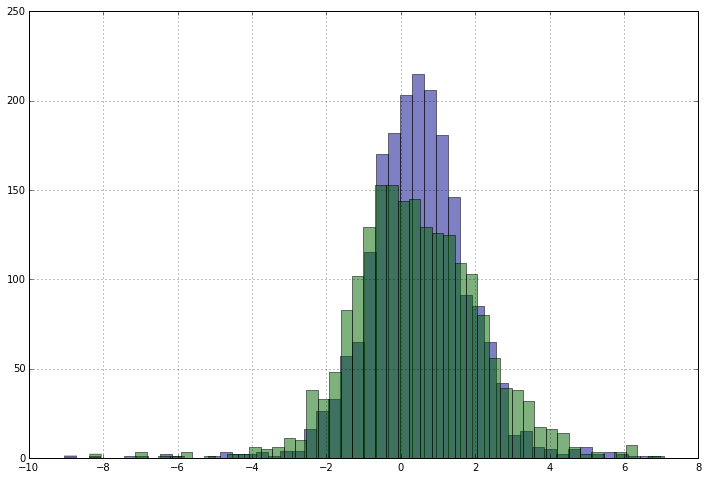

In [32]:
ax = paired_picks_df.PcP_P_dtime_resid.hist(bins=50, color='DarkBlue', alpha=0.5)
paired_picks_df.PcP_P_dtime_corrected_resid.hist(bins=50, color='DarkGreen', alpha=0.5, ax=ax)

## Store the results
So we can do additional analysis

In [33]:
paired_picks_df.to_pickle('processed_data.pkl')

In [34]:
print paired_picks_df

                      eventid              P_datetime  station_lon reporter  \
600130102GTABJI     600130102 2012-01-01 00:38:39.200      99.8144      BJI   
600130102GYABJI     600130102 2012-01-01 00:37:21.200     106.6640      BJI   
600130102KLRIDC     600130102 2012-01-01 00:37:25.400     131.7500      IDC   
600130102KSHBJI     600130102 2012-01-01 00:40:50.000      75.9731      BJI   
600130102PETKIDC    600130102 2012-01-01 00:38:00.270     157.6989      IDC   
600130102SONMIDC    600130102 2012-01-01 00:38:39.360     106.3950      IDC   
600130102ZALVIDC    600130102 2012-01-01 00:40:26.100      84.8188      IDC   
600130103AS01NEIC   600130103 2012-01-01 00:56:35.790     133.9510     NEIC   
600130103ASARIDC    600130103 2012-01-01 00:56:36.100     133.9040      IDC   
600130103STKAIDC    600130103 2012-01-01 00:56:15.400     141.5952      IDC   
600130103STKANEIC   600130103 2012-01-01 00:56:15.970     141.5952     NEIC   
600130103WRAIDC     600130103 2012-01-01 00:56:25.97